In [222]:
import pygame
import random
import math
import numpy as np

# test mode 1 : without considering reliability and no baseian inference, 
# test mode 2 : reliability and no bayesian infernece
# test mode 3 : reliabilithy and bayesian inference
class BallCatchingEnvPygame:
    def __init__(self, width=800, height=600, render_mode=True, automode = 1, num_episodes = 100, testmode = 1): # 중심점이 (400, 300)
        pygame.init()  # pygame 초기화 (필수)
        self.width = width
        self.height = height
        self.render_mode = render_mode
        self.screen = pygame.display.set_mode((self.width, self.height))  # 화면 초기화

        self.left_target = (-200, 0)  # 왼쪽 목표 위치
        self.right_target = (200, 0)  # 오른쪽 목표 위치
        self.radius = 50  # 공이 들어오는 원의 반지름
        self.speed = 10
        self.BallNumber = 0
        self.LC = 0
        self.RI = 0
        self.automode = automode
        self.blockN = num_episodes // 20 # 20 blocks
        self.current_episode = 1
        self.testmode = testmode
        self.trial_history = []
        self.belief = 0  # base probability
        self.reset()


    def reset(self):
        self.left_balls = [self.generate_random_ball(self.left_target) for _ in range(6)]
        self.right_balls = [self.generate_random_ball(self.right_target) for _ in range(6)]
        self.agentPasstime = 1  
        self.agentPosition = [0, 0] # 에이전트의 초기 위치
        self.done = False
        self.BallNumber = 0
        return self.get_state()

    def generate_random_ball(self, target):
        distance = random.uniform(150, 250)
        angle = random.uniform(0, math.pi * 2)
        return {'x': target[0] + distance * math.cos(angle), 'y': target[1] + distance * math.sin(angle), 'angle': angle, 'toward' : True}

    def step(self, action):
        if self.done:
            return self.get_state(), 0, True, {}

        # 공들을 이동시켜 원안으로 들어오게 함 (속도 차이 적용)
        self.move_balls()
        # 공이 원 안에 들어온 개수 카운트
        leftBallN = sum(self.is_in_range(ball, self.left_target) for ball in self.left_balls)
        rightBallN = sum(self.is_in_range(ball, self.right_target) for ball in self.right_balls)

        reward = 0

        if self.automode == 1 :
            move_step = 70 # 기계가 하면 50, 사람이 하면 201로
        else :
            move_step = 200

        # block counter, 블럭마다 보상을 뒤집음 for reliability
        if self.testmode == 1 :
            slow_reward = 1
            fast_reward = 1
        else :
            now_block = self.current_episode // self.blockN + 1
            if now_block % 2 == 1 :
                slow_reward = 0.8
                fast_reward = 0.2
            else :
                slow_reward = 0.2
                fast_reward = 0.8

        if action == 0 : # 왼쪽
            self.agentPosition[0] -= move_step
            if self.agentPosition[0] < -150 :
                if leftBallN == 0 :
                    reward -= 2
                else : # 왼쪽 선택
                    reward += leftBallN * self.agentPasstime * slow_reward # 잘 고른거
            self.ballNumber = leftBallN
        if action == 1 : # 오른쪽
            self.agentPosition[0] += move_step
            if self.agentPosition[0] > 150 :
                if rightBallN == 0 :
                    reward -= 2
                else : # 오른쪽 공 선택
                    reward += rightBallN * self.agentPasstime * fast_reward      
            self.BallNumber = rightBallN

        self.agentPasstime +=1 # 시간경과 표시
        if self.agentPasstime == 29 : # 종료할때까지 끝을 못내는경우
            reward = -1
        # 종료 조건: 공이 원 안에 들어오면 종료, 20회 대기하면 끝
        self.done = self.agentPosition[0] > 150 or self.agentPosition[0] < -150 or self.agentPasstime == 29
        
        if self.done :
            if self.agentPosition[0] < -150 :
                self.LC += 1
                pos = 0
            elif self.agentPosition[0] > 150 :
                self.RI += 1
                pos = 1
            else :
                pos = 2
            self.current_episode += 1 # episode 수 업데이트
            # 매 끝날때마다 기록, 이를 기준으로 판단

            self.trial_history.append((pos, reward)) # history update
            # if len(self.trial_history) > 30: # 최근 30번의 history를 기록
                # self.trial_history.pop(0)            

        return self.get_state(), reward, self.done, self.BallNumber, self.LC, self.RI, {}

    def move_balls(self):
        # 좌측 공들 이동
        for ball in self.left_balls:
            dist = math.hypot(ball['x'] - self.left_target[0], ball['y'] - self.left_target[1])

            if not ball['toward'] and dist > 150 : # 중심을 벗어나고, 150이상 넘어가면
                ball['toward'] = True
                ball['angle'] += math.pi # 방향을 바꿈
            elif ball['toward'] and dist < 50 : # 중심을 넘어가면
                ball['toward'] = False # 넘어갔다고 바꿔주기

            if dist < 50 : # 원 안에서 공이 감속, 왼쪽
                ball['x'] -= self.speed / 10 * math.cos(ball['angle'])
                ball['y'] -= self.speed/ 10 * math.sin(ball['angle'])
            else :
                ball['x'] -= self.speed * math.cos(ball['angle'])
                ball['y'] -= self.speed * math.sin(ball['angle'])               
        # 우측 공들 이동
        for ball in self.right_balls:
            dist = math.hypot(ball['x'] - self.right_target[0], ball['y'] - self.right_target[1])
            if not ball['toward'] and dist > 150 :
                ball['toward'] = True
                ball['angle'] += math.pi
            elif ball['toward'] and dist < 50 :
                ball['toward'] = False
            ball['x'] -= self.speed * 1.5 * math.cos(ball['angle'])
            ball['y'] -= self.speed * 1.5 * math.sin(ball['angle'])


    def get_state(self):
        # 상태를 에이전트의 위치, 왼쪽 공 개수, 오른쪽 공 개수, 시간으로 반환
        left_count = sum(self.is_in_range(ball, self.left_target) for ball in self.left_balls)
        right_count = sum(self.is_in_range(ball, self.right_target) for ball in self.right_balls)
        if self.testmode == 3 :     
            return (self.agentPasstime, left_count, right_count, self.belief)
        return (self.agentPasstime, left_count, right_count) # 좌우 공 개수로 어디 더 괜찮은지 competency를 찾아냄

    def is_in_range(self, ball, target):
        # 공이 3도 범위 내로 들어왔는지 확인
        dist = math.sqrt((target[0] - ball['x'])**2 + (target[1] - ball['y'])**2)
        return dist < 50
    
    def update_belief(self, window=5):
        # 최근 window개 트라이얼에서 좌측과 우측의 보상 합산
        recent_history = self.trial_history[-window:]
        
        left_rewards = 0
        right_rewards = 0
        
        for entry in recent_history:
            # entry = (action, reward) 형태라고 가정
            pos, reward = entry
            if pos == 0:
                left_rewards += reward
            elif pos == 1:
                right_rewards += reward
        
        # 보상이 더 높은 쪽을 belief로 설정 (0=left, 1=right)
        if left_rewards > right_rewards:
            self.belief = 0
        elif right_rewards > left_rewards:
            self.belief = 1
        else:
            self.belief = random.choice([0,1])  # 동점일 경우 랜덤          
        
    def render(self):
        if not self.render_mode:
            return

        # 화면 초기화
        self.screen.fill((213, 213, 213))

        # 목표 위치 그리기
        pygame.draw.circle(self.screen, (0, 0, 255), (self.width * 2 // 8, self.height // 2), self.radius, 2)
        pygame.draw.circle(self.screen, (255, 0, 0), (self.width * 6 // 8, self.height // 2), self.radius, 2)
        pygame.draw.circle(self.screen, (0, 0, 0), (self.width // 2, self.height // 2), 5, 5) # fixation point


        # 공 그리기
        for ball in self.left_balls:
            pygame.draw.circle(self.screen, (0, 0, 255), (int(ball['x'] + self.width // 2), int(ball['y'] + self.height // 2)), 5)

        for ball in self.right_balls:
            pygame.draw.circle(self.screen, (255, 0, 0), (int(ball['x'] + self.width// 2), int(ball['y'] + self.height // 2)), 5)

        pygame.draw.circle(self.screen, (0, 255, 0), (int(self.agentPosition[0] + self.width // 2), int(self.agentPosition[1] + self.height // 2)), 10)
        # 화면 업데이트
        pygame.display.update()

    def close(self):
        pygame.quit()  # 게임 종료 시 pygame 종료



In [226]:
import random
import numpy as np

class SARSAAgent:
    def __init__(self, action_space, alpha=0.7, gamma=0.5, epsilon=0.9):
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}  # 기본 Q테이블로 시작


    def get_action(self, state):
        Q = self.Q

        # 상태가 처음 나오는 경우 초기화
        if state not in Q:
            Q[state] = {a: 0.0 for a in [0, 1, 2]}

        if random.random() < self.epsilon:
            return random.choice([0, 1, 2])  # explore
        else:
            return max(Q[state], key=Q[state].get)  # exploit
        
    def update(self, state, action, reward, next_state, next_action):
        Q = self.Q

        if state not in Q:
            Q[state] = {a: 0.0 for a in [0, 1, 2]}

        if next_state not in Q:
            Q[next_state] = {a: 0.0 for a in [0, 1, 2]}

        q_predict = Q[state][action]
        q_target = reward + self.gamma * Q[next_state][next_action]
        Q[state][action] += self.alpha * (q_target - q_predict)


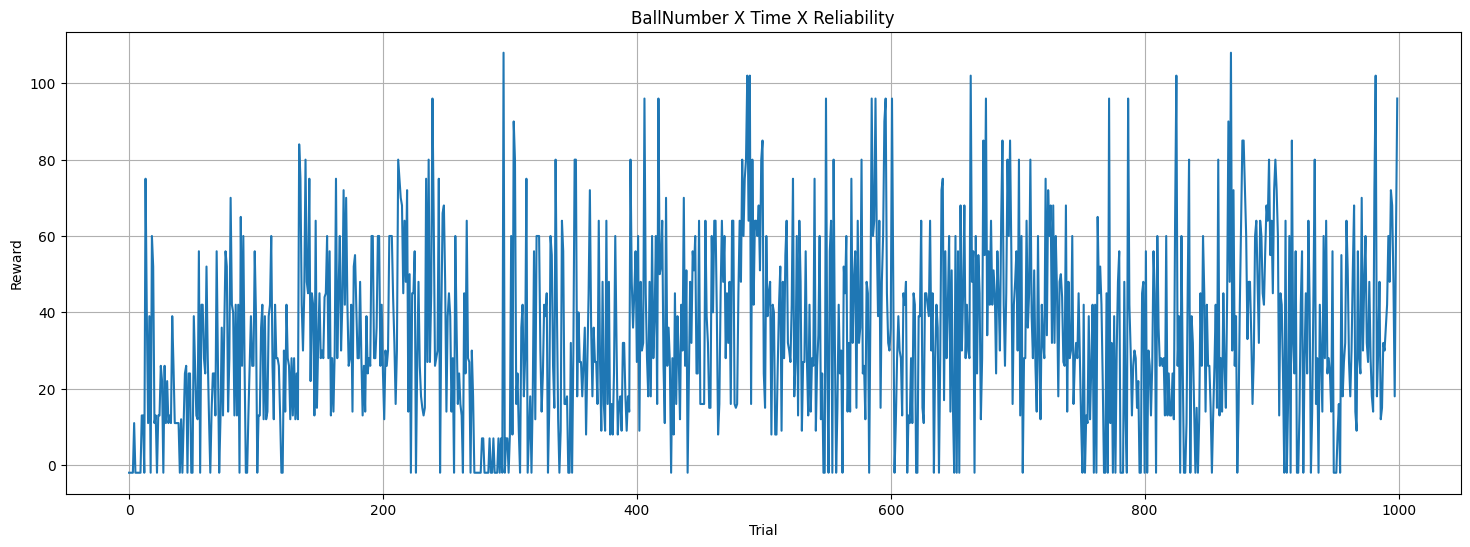

In [239]:
## test mode 1, fixed probability
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import curve_fit

def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))


# 학습 설정, 강화학습으로 진행함
num_episodes = 1000
env = BallCatchingEnvPygame(render_mode=False, automode=1, num_episodes=num_episodes, testmode=1)
agent = SARSAAgent(action_space=[0, 1, 2], epsilon=0.01)  # 0: 왼쪽, 1: 오른쪽, 2: 기다림
env.render()
ballNumber = np.zeros(num_episodes)
WaitTime = np.zeros(num_episodes)
select = np.zeros(num_episodes) # 좌 선택은 0 우 선택은 1, 기본은 다 0으로로
Reward = np.zeros(num_episodes)

LC = 0
RI = 0

tmp_LC = 0
tmp_RI = 0

for episode in range(num_episodes):
    state = env.reset()
    action = agent.get_action(state)
    total_reward = 0
    total_time = 0

    while True:
        #time.sleep(0.075)
        next_state, reward, done, BallNumber, LC, RI, _ = env.step(action)
        env.render()
        next_action = agent.get_action(next_state)

        agent.update(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
        total_reward += reward
        total_time += 1
        ball_number = BallNumber
        if RI != tmp_RI :
            select[episode] = 1
            tmp_RI = RI

        if done:
            #time.sleep(0.3)
            break

    ballNumber[episode] = ball_number
    WaitTime[episode] = total_time
    Reward[episode] = reward

# 환경 종료
env.close()

# 트라이얼에 따라 나타난 결과
plt.figure(figsize=(18, 6))
plt.plot(Reward)
plt.xlabel('Trial')
plt.ylabel('Reward')
plt.title('BallNumber X Time X Reliability')
plt.grid()
plt.show()


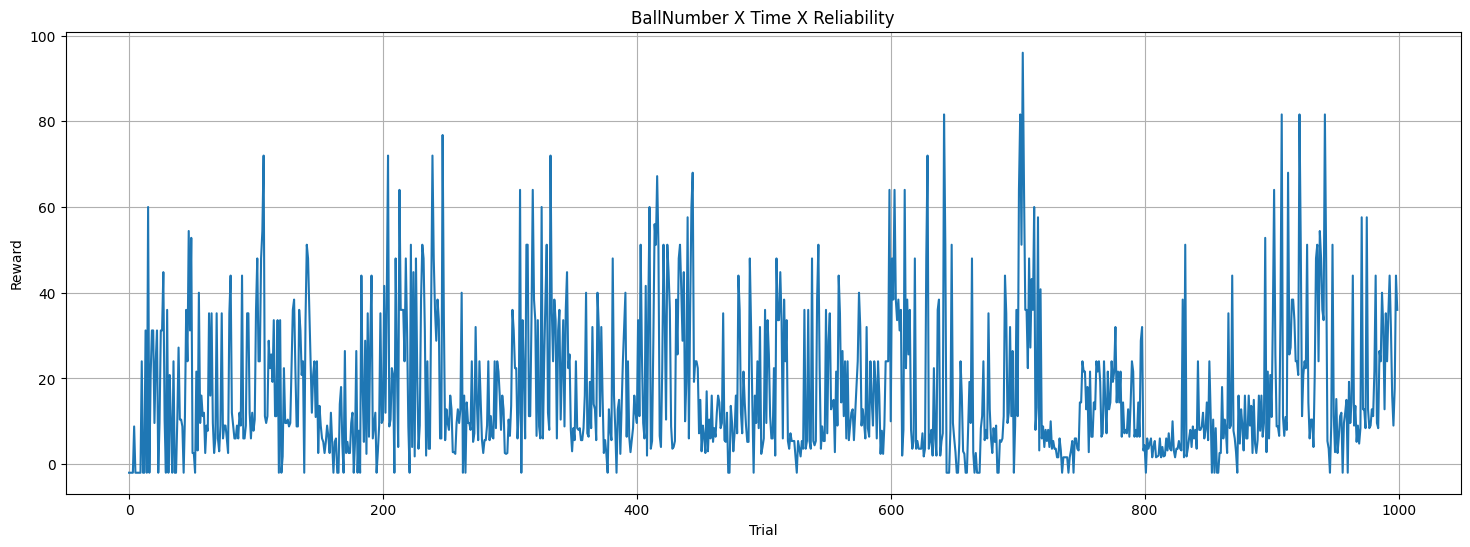

In [240]:
## test mode 2, probability change no baysian inference
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import curve_fit

def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))


# 학습 설정, 강화학습으로 진행함
num_episodes = 1000
env = BallCatchingEnvPygame(render_mode=False, automode=1, num_episodes=num_episodes, testmode=2)
agent = SARSAAgent(action_space=[0, 1, 2], epsilon=0.01)  # 0: 왼쪽, 1: 오른쪽, 2: 기다림
env.render()
ballNumber = np.zeros(num_episodes)
WaitTime = np.zeros(num_episodes)
select = np.zeros(num_episodes) # 좌 선택은 0 우 선택은 1, 기본은 다 0으로로
Reward = np.zeros(num_episodes)

LC = 0
RI = 0

tmp_LC = 0
tmp_RI = 0

for episode in range(num_episodes):
    state = env.reset()
    action = agent.get_action(state)
    total_reward = 0
    total_time = 0

    while True:
        #time.sleep(0.075)
        next_state, reward, done, BallNumber, LC, RI, _ = env.step(action)
        env.render()
        next_action = agent.get_action(next_state)

        agent.update(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
        total_reward += reward
        total_time += 1
        ball_number = BallNumber
        if RI != tmp_RI :
            select[episode] = 1
            tmp_RI = RI

        if done:
            #time.sleep(0.3)
            break

    ballNumber[episode] = ball_number
    WaitTime[episode] = total_time
    Reward[episode] = reward

# 환경 종료
env.close()

#트라이얼에 따라 나타난 결과
plt.figure(figsize=(18, 6))
plt.plot(Reward)
plt.xlabel('Trial')
plt.ylabel('Reward')
plt.title('BallNumber X Time X Reliability')
plt.grid()
plt.show()

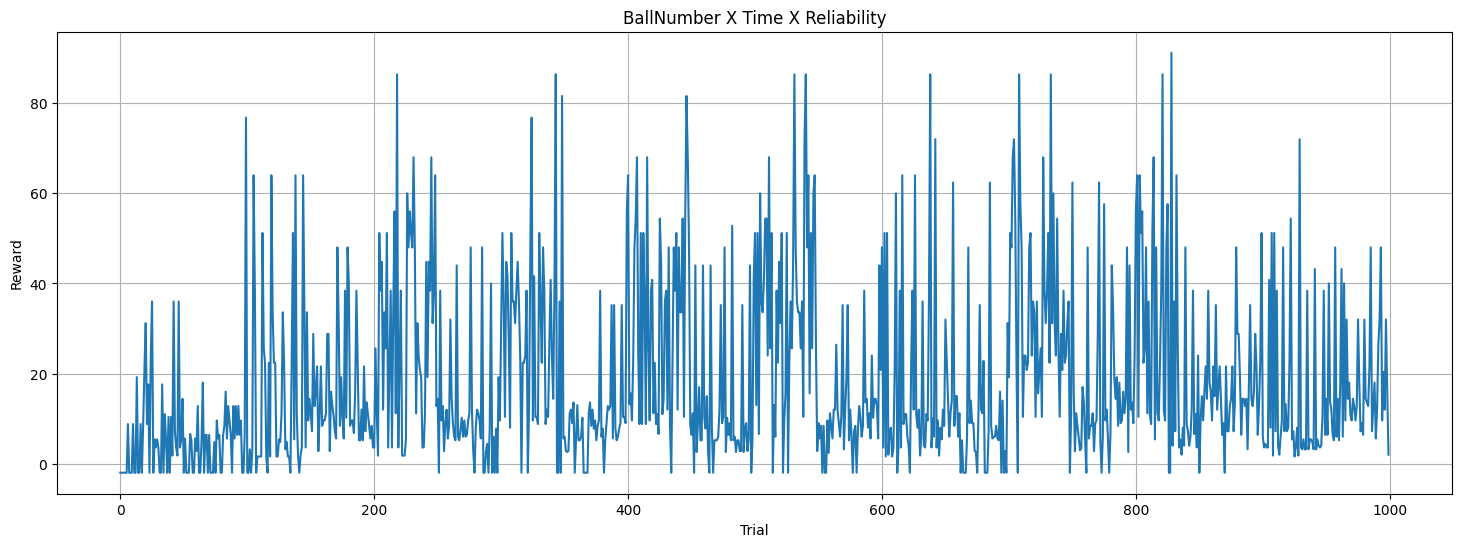

In [243]:
## test mode 3, probability change, bayesian inference
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import curve_fit

def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))


# 학습 설정, 강화학습으로 진행함
num_episodes = 1000
env = BallCatchingEnvPygame(render_mode=False, automode=1, num_episodes=num_episodes, testmode=3)
agent = SARSAAgent(action_space=[0, 1, 2], epsilon=0.01)  # 0: 왼쪽, 1: 오른쪽, 2: 기다림
env.render()
ballNumber = np.zeros(num_episodes)
WaitTime = np.zeros(num_episodes)
select = np.zeros(num_episodes) # 좌 선택은 0 우 선택은 1, 기본은 다 0으로로
Reward = np.zeros(num_episodes)

LC = 0
RI = 0

tmp_LC = 0
tmp_RI = 0

for episode in range(num_episodes):
    state = env.reset()
    action = agent.get_action(state)
    total_reward = 0
    total_time = 0

    while True:
       # time.sleep(0.075)
        # epsilon decay
        next_state, reward, done, BallNumber, LC, RI, _ = env.step(action)
        env.render()
        next_action = agent.get_action(next_state)
        agent.update(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
        total_reward += reward
        total_time += 1
        ball_number = BallNumber

        if RI != tmp_RI :
            select[episode] = 1
            tmp_RI = RI
        if done:
            env.update_belief()
            break

    ballNumber[episode] = ball_number
    WaitTime[episode] = total_time
    Reward[episode] = reward

# 환경 종료
env.close()

# 트라이얼에 따라 나타난 결과
plt.figure(figsize=(18, 6))
plt.plot(Reward)
plt.xlabel('Trial')
# plt.ylabel('Ev Value')
plt.ylabel('Reward')
plt.title('BallNumber X Time X Reliability')
plt.grid()
plt.show()
